In [1]:
# Imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

# Add src to path
workspace_root = Path().cwd()
sys.path.insert(0, str(workspace_root / 'src'))

# Thesis pipeline utilities
from thesis_pipeline.io.paths import get_data_path
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# BERTopic
from bertopic import BERTopic

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings('ignore')

print("✓ All imports successful")

✓ All imports successful


## 1. Load BERTopic Results

Load fitted BERTopic model and document assignments from notebook 15a.

In [2]:
# Paths
bertopic_path = get_data_path('topics', 'reddit') / 'bertopic'
output_path = bertopic_path / 'quality_checks'
output_path.mkdir(exist_ok=True)

print(f"BERTopic data: {bertopic_path}")
print(f"Output: {output_path}")

BERTopic data: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/bertopic
Output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/bertopic/quality_checks


In [3]:
# Load thread pseudo-documents with BERTopic assignments
thread_docs = read_parquet(bertopic_path / 'thread_pseudodocs_with_bertopics.parquet')

# Load topic summaries
topic_summaries = read_parquet(bertopic_path / 'bertopic_summaries.parquet')

# Load metadata
with open(bertopic_path / 'bertopic_model_metadata.json', 'r') as f:
    metadata = json.load(f)

# Load BERTopic model (for additional queries if needed)
topic_model = BERTopic.load(str(bertopic_path / 'bertopic_model'))

N_TOPICS = metadata['model']['n_topics_discovered']

print(f"Loaded data:")
print(f"  Thread documents: {len(thread_docs):,}")
print(f"  Topics: {N_TOPICS}")
print(f"  Documents with topics: {(thread_docs['bertopic_id'] != -1).sum():,}")
print(f"  Outliers: {(thread_docs['bertopic_id'] == -1).sum():,} ({(thread_docs['bertopic_id'] == -1).mean():.1%})")
print(f"\nModel details:")
print(f"  Algorithm: {metadata['model']['algorithm']}")
print(f"  Embedding: {metadata['model']['embedding_model']}")

2025-12-20 09:35:53,545 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


Loaded data:
  Thread documents: 433,973
  Topics: 24
  Documents with topics: 433,973
  Outliers: 0 (0.0%)

Model details:
  Algorithm: BERTopic
  Embedding: all-MiniLM-L6-v2


## 2. Topic Quality Evaluation

Apply same fast heuristics as notebook 16 for fair comparison with STM/NMF.

In [4]:
# Fast topic quality assessment using heuristics

print("="*60)
print("FAST TOPIC QUALITY ASSESSMENT (BERTopic)")
print("="*60)

# Same common words set as STM assessment
COMMON_WORDS = {
    'like', 'just', 'know', 'think', 'really', 'people', 'time', 'good', 'make',
    'want', 'right', 'sure', 'thing', 'way', 'going', 'need', 'look', 'year',
    'come', 'tell', 'work', 'feel', 'say', 'try', 'point', 'kind', 'take',
    'use', 'give', 'believe', 'probably', 'pretty', 'lot', 'actually', 'quite',
    'fucking', 'shit', 'hell', 'damn', 'fuck',
    'don', 'isn', 'doesn', 'wasn', 'won', 'wouldn', 'couldn', 'shouldn',
    'let', 'got', 'getting', 'keep', 'start', 'maybe', 'guess', 'mean'
}

# 1. Stopword contamination check
print("\n1. Checking stopword contamination...")

stopword_scores = []
for i in range(N_TOPICS):
    top_words = topic_summaries.iloc[i]['top_words'][:10]  # Top 10 words
    n_common = sum(1 for word in top_words if word in COMMON_WORDS)
    contamination_rate = n_common / len(top_words)
    stopword_scores.append(contamination_rate)

topic_summaries['stopword_contamination'] = stopword_scores

# Flag highly contaminated topics (>40% common words)
CONTAMINATION_THRESHOLD = 0.4
topic_summaries['high_contamination'] = topic_summaries['stopword_contamination'] > CONTAMINATION_THRESHOLD

print(f"  Mean contamination: {np.mean(stopword_scores):.1%}")
print(f"  Topics with high contamination (>{CONTAMINATION_THRESHOLD:.0%}): {topic_summaries['high_contamination'].sum()}")

if topic_summaries['high_contamination'].any():
    print(f"\n  Contaminated topics:")
    contaminated = topic_summaries[topic_summaries['high_contamination']].nlargest(5, 'stopword_contamination')
    for _, row in contaminated.iterrows():
        print(f"    Topic {row['topic_id']:2d} ({row['stopword_contamination']:.0%} common): {row['top_words_str'][:80]}...")

FAST TOPIC QUALITY ASSESSMENT (BERTopic)

1. Checking stopword contamination...
  Mean contamination: 0.0%
  Topics with high contamination (>40%): 0


In [5]:
# 2. Word distinctiveness using c-TF-IDF weights
print("\n2. Checking word distinctiveness...")

# BERTopic uses c-TF-IDF weights (already in word_weights column)
distinctiveness_scores = []

for i in range(N_TOPICS):
    word_weights = topic_summaries.iloc[i]['word_weights'][:10]  # Top 10 word weights
    mean_weight = np.mean(word_weights)
    distinctiveness_scores.append(mean_weight)

topic_summaries['word_distinctiveness'] = distinctiveness_scores

# Flag low distinctiveness topics (bottom 20%)
distinctiveness_threshold = np.percentile(distinctiveness_scores, 20)
topic_summaries['low_distinctiveness'] = topic_summaries['word_distinctiveness'] < distinctiveness_threshold

print(f"  Mean distinctiveness: {np.mean(distinctiveness_scores):.4f}")
print(f"  Threshold (bottom 20%): {distinctiveness_threshold:.4f}")
print(f"  Topics with low distinctiveness: {topic_summaries['low_distinctiveness'].sum()}")

if topic_summaries['low_distinctiveness'].any():
    print(f"\n  Low distinctiveness topics:")
    low_dist = topic_summaries[topic_summaries['low_distinctiveness']].nsmallest(5, 'word_distinctiveness')
    for _, row in low_dist.iterrows():
        print(f"    Topic {row['topic_id']:2d} (weight={row['word_distinctiveness']:.4f}): {row['top_words_str'][:80]}...")


2. Checking word distinctiveness...
  Mean distinctiveness: 0.0163
  Threshold (bottom 20%): 0.0047
  Topics with low distinctiveness: 5

  Low distinctiveness topics:
    Topic  3 (weight=0.0018): pianos, isds, released tax, charity navigator, lost billion, ipcc, tax records, ...
    Topic  5 (weight=0.0033): malik obama, larry king, d0, city syria, half brother, kiev, fairtax, johnson al...
    Topic 23 (weight=0.0034): sniff sniff, clean coal, sniffling, chinese steel, van jones, sniffs, better tem...
    Topic 10 (weight=0.0039): partial birth, otc, term abortion, birth abortion, abortion murder, embryo, unbo...
    Topic  7 (weight=0.0043): kratom, opioid, naloxone, fentanyl, frisked, thc, opioids, ubc, awb, shotguns...


In [6]:
# 3. Topic specificity using entropy
print("\n3. Checking topic specificity (entropy)...")

specificity_scores = []

for i in range(N_TOPICS):
    word_weights = topic_summaries.iloc[i]['word_weights'][:15]  # Top 15 words
    # Normalize to probability distribution
    probs = np.array(word_weights) / np.sum(word_weights)
    topic_entropy = entropy(probs)
    specificity_scores.append(topic_entropy)

topic_summaries['entropy'] = specificity_scores

# Flag high entropy topics (top 20% = least specific)
entropy_threshold = np.percentile(specificity_scores, 80)
topic_summaries['unfocused'] = topic_summaries['entropy'] > entropy_threshold

print(f"  Mean entropy: {np.mean(specificity_scores):.3f}")
print(f"  Threshold (top 20%): {entropy_threshold:.3f}")
print(f"  Unfocused topics (high entropy): {topic_summaries['unfocused'].sum()}")

if topic_summaries['unfocused'].any():
    print(f"\n  Unfocused topics:")
    unfocused = topic_summaries[topic_summaries['unfocused']].nlargest(5, 'entropy')
    for _, row in unfocused.iterrows():
        print(f"    Topic {row['topic_id']:2d} (entropy={row['entropy']:.3f}): {row['top_words_str'][:80]}...")

print("\n✓ Quality assessment complete")


3. Checking topic specificity (entropy)...
  Mean entropy: 2.560
  Threshold (top 20%): 2.671
  Unfocused topics (high entropy): 5

  Unfocused topics:
    Topic  1 (entropy=2.690): fuck spez, politicalhumor, political_revolution rules, discussion news, com poli...
    Topic 23 (entropy=2.679): sniff sniff, clean coal, sniffling, chinese steel, van jones, sniffs, better tem...
    Topic 12 (entropy=2.679): dysphoria, mrm, femradebates, men issues, mras, gender dysphoria, objectificatio...
    Topic 20 (entropy=2.678): sue saudi, advice consent, sovereign immunity, advise consent, consent senate, q...
    Topic 10 (entropy=2.673): partial birth, otc, term abortion, birth abortion, abortion murder, embryo, unbo...

✓ Quality assessment complete


## 3. Visualize Quality Metrics

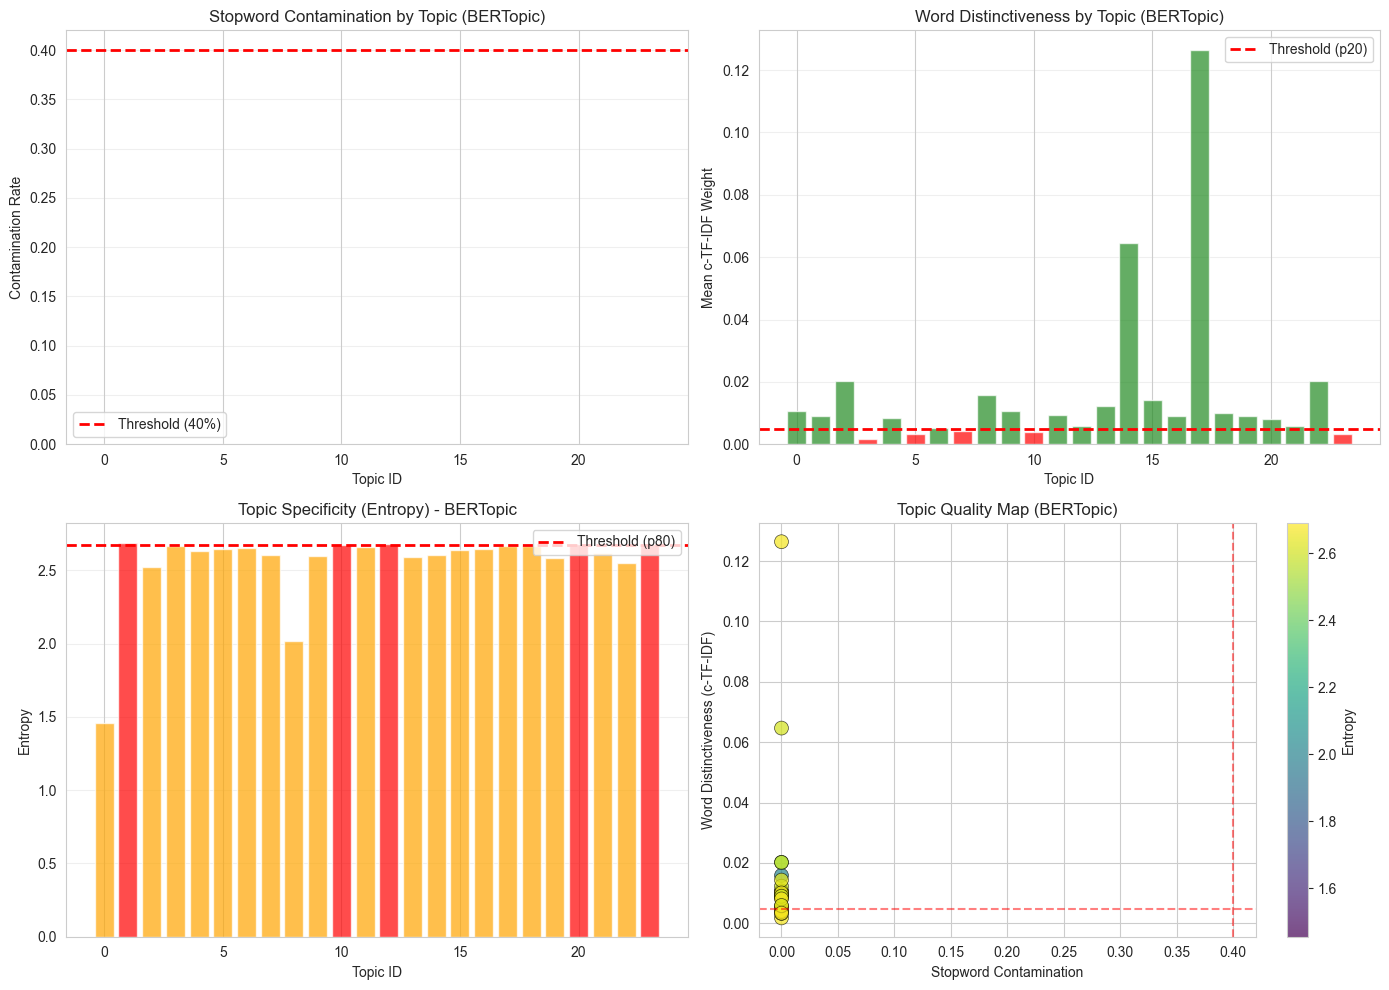

✓ Saved plot: quality_metrics.png


In [7]:
# Visualize quality metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Stopword contamination
axes[0, 0].bar(range(N_TOPICS), topic_summaries['stopword_contamination'], 
               color=['red' if x else 'steelblue' for x in topic_summaries['high_contamination']],
               alpha=0.7)
axes[0, 0].axhline(CONTAMINATION_THRESHOLD, color='red', linestyle='--', linewidth=2, 
                   label=f'Threshold ({CONTAMINATION_THRESHOLD:.0%})')
axes[0, 0].set_xlabel('Topic ID')
axes[0, 0].set_ylabel('Contamination Rate')
axes[0, 0].set_title('Stopword Contamination by Topic (BERTopic)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Word distinctiveness
axes[0, 1].bar(range(N_TOPICS), topic_summaries['word_distinctiveness'],
               color=['red' if x else 'forestgreen' for x in topic_summaries['low_distinctiveness']],
               alpha=0.7)
axes[0, 1].axhline(distinctiveness_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Threshold (p20)')
axes[0, 1].set_xlabel('Topic ID')
axes[0, 1].set_ylabel('Mean c-TF-IDF Weight')
axes[0, 1].set_title('Word Distinctiveness by Topic (BERTopic)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Entropy (specificity)
axes[1, 0].bar(range(N_TOPICS), topic_summaries['entropy'],
               color=['red' if x else 'orange' for x in topic_summaries['unfocused']],
               alpha=0.7)
axes[1, 0].axhline(entropy_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Threshold (p80)')
axes[1, 0].set_xlabel('Topic ID')
axes[1, 0].set_ylabel('Entropy')
axes[1, 0].set_title('Topic Specificity (Entropy) - BERTopic')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Scatter: Contamination vs Distinctiveness
scatter = axes[1, 1].scatter(
    topic_summaries['stopword_contamination'],
    topic_summaries['word_distinctiveness'],
    c=topic_summaries['entropy'],
    cmap='viridis',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
axes[1, 1].axvline(CONTAMINATION_THRESHOLD, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(distinctiveness_threshold, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Stopword Contamination')
axes[1, 1].set_ylabel('Word Distinctiveness (c-TF-IDF)')
axes[1, 1].set_title('Topic Quality Map (BERTopic)')
plt.colorbar(scatter, ax=axes[1, 1], label='Entropy')

plt.tight_layout()
plt.savefig(output_path / 'quality_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved plot: quality_metrics.png")

## 4. Temporal Persistence Analysis

Check topic persistence across days (excluding outlier topic -1).

In [8]:
# Create date column for temporal analysis
thread_docs['date'] = pd.to_datetime(thread_docs['created_utc'], unit='s').dt.date

# Filter out outliers
valid_docs = thread_docs[thread_docs['bertopic_id'] != -1].copy()

# Count unique days in dataset
n_days = valid_docs['date'].nunique()
print(f"Dataset spans {n_days} days (excluding outliers)")
print(f"Date range: {valid_docs['date'].min()} to {valid_docs['date'].max()}")

Dataset spans 61 days (excluding outliers)
Date range: 2016-09-01 to 2016-10-31


In [9]:
# Compute persistence for each topic
PERSISTENCE_THRESHOLD = 0.20  # Topic must be present on ≥20% of days

topic_persistence = []

# Days where each topic appears
daily_topic_counts = valid_docs.groupby(['date', 'bertopic_id']).size().reset_index(name='count')

for topic_idx in range(N_TOPICS):
    # Get actual topic_id from summaries (BERTopic IDs may not be 0-indexed)
    actual_topic_id = topic_summaries.iloc[topic_idx]['topic_id']
    
    # Days where this topic appears
    topic_days = daily_topic_counts[daily_topic_counts['bertopic_id'] == actual_topic_id]['date'].unique()
    n_days_present = len(topic_days)
    
    persistence = n_days_present / n_days
    topic_persistence.append(persistence)

# Add to summaries
topic_summaries['persistence'] = topic_persistence
topic_summaries['low_persistence'] = topic_summaries['persistence'] < PERSISTENCE_THRESHOLD

print(f"Persistence analysis:")
print(f"  Persistence threshold: {PERSISTENCE_THRESHOLD:.1%} of days")
print(f"  Mean persistence: {np.mean(topic_persistence):.1%}")
print(f"  Median persistence: {np.median(topic_persistence):.1%}")
print(f"  Min persistence: {np.min(topic_persistence):.1%} (topic {topic_summaries.iloc[np.argmin(topic_persistence)]['topic_id']})")
print(f"  Max persistence: {np.max(topic_persistence):.1%} (topic {topic_summaries.iloc[np.argmax(topic_persistence)]['topic_id']})")
print(f"\nLow persistence topics: {topic_summaries['low_persistence'].sum()}")

if topic_summaries['low_persistence'].sum() > 0:
    print(f"\nTopics with low persistence:")
    low_persist = topic_summaries[topic_summaries['low_persistence']][['topic_id', 'persistence', 'top_words_str']]
    for _, row in low_persist.iterrows():
        print(f"  Topic {row['topic_id']:2d} ({row['persistence']:.1%}): {row['top_words_str'][:80]}...")

Persistence analysis:
  Persistence threshold: 20.0% of days
  Mean persistence: 99.4%
  Median persistence: 100.0%
  Min persistence: 93.4% (topic 17)
  Max persistence: 100.0% (topic 0)

Low persistence topics: 0


## 5. Volume Check

In [10]:
# Check minimum daily volume for each topic
MIN_DAILY_DOCS = 5  # Minimum documents per day-topic

# For each topic, compute volume statistics
topic_volume_stats = []

for i in range(N_TOPICS):
    actual_topic_id = topic_summaries.iloc[i]['topic_id']
    topic_daily = daily_topic_counts[daily_topic_counts['bertopic_id'] == actual_topic_id]['count']
    
    if len(topic_daily) > 0:
        stats = {
            'topic_id': actual_topic_id,
            'n_days_present': len(topic_daily),
            'mean_daily_docs': topic_daily.mean(),
            'median_daily_docs': topic_daily.median(),
            'min_daily_docs': topic_daily.min(),
            'days_below_threshold': (topic_daily < MIN_DAILY_DOCS).sum(),
            'pct_days_below_threshold': (topic_daily < MIN_DAILY_DOCS).mean()
        }
    else:
        stats = {
            'topic_id': actual_topic_id,
            'n_days_present': 0,
            'mean_daily_docs': 0,
            'median_daily_docs': 0,
            'min_daily_docs': 0,
            'days_below_threshold': 0,
            'pct_days_below_threshold': 1.0
        }
    
    topic_volume_stats.append(stats)

volume_df = pd.DataFrame(topic_volume_stats)

# Flag topics with frequent low volume days (>50% of days below threshold)
volume_df['low_volume'] = volume_df['pct_days_below_threshold'] > 0.5

# Merge with summaries
topic_summaries = topic_summaries.merge(
    volume_df[['topic_id', 'mean_daily_docs', 'median_daily_docs', 'days_below_threshold', 
               'pct_days_below_threshold', 'low_volume']], 
    on='topic_id'
)

print(f"Volume analysis (threshold: {MIN_DAILY_DOCS} docs/day):")
print(f"  Mean daily docs across topics: {volume_df['mean_daily_docs'].mean():.1f}")
print(f"  Median daily docs across topics: {volume_df['median_daily_docs'].median():.1f}")
print(f"\nLow volume topics (>50% days below threshold): {topic_summaries['low_volume'].sum()}")

if topic_summaries['low_volume'].sum() > 0:
    print(f"\nTopics with low volume:")
    low_vol = topic_summaries[topic_summaries['low_volume']][
        ['topic_id', 'mean_daily_docs', 'pct_days_below_threshold', 'top_words_str']
    ]
    for _, row in low_vol.iterrows():
        print(f"  Topic {row['topic_id']:2d} (mean={row['mean_daily_docs']:.1f}, {row['pct_days_below_threshold']:.0%} low): "
              f"{row['top_words_str'][:60]}...")

Volume analysis (threshold: 5 docs/day):
  Mean daily docs across topics: 296.6
  Median daily docs across topics: 39.5

Low volume topics (>50% days below threshold): 2

Topics with low volume:
  Topic 17 (mean=29.1, 60% low): 16 30pm, pepe rise, crash analysts, maket experienced, pdt p...
  Topic 23 (mean=12.6, 62% low): sniff sniff, clean coal, sniffling, chinese steel, van jones...


## 6. Filtering Decision and Quality Summary

In [11]:
# Create composite quality flag (same criteria as STM)
topic_summaries['passes_all_checks'] = (
    ~topic_summaries['high_contamination'] & 
    ~topic_summaries['low_distinctiveness'] & 
    ~topic_summaries['unfocused'] &
    ~topic_summaries['low_persistence'] & 
    ~topic_summaries['low_volume']
)

# Count failures by type
n_contamination_fail = topic_summaries['high_contamination'].sum()
n_distinctiveness_fail = topic_summaries['low_distinctiveness'].sum()
n_unfocused_fail = topic_summaries['unfocused'].sum()
n_persistence_fail = topic_summaries['low_persistence'].sum()
n_volume_fail = topic_summaries['low_volume'].sum()
n_pass = topic_summaries['passes_all_checks'].sum()

print("="*60)
print("BERTOPIC QUALITY SUMMARY")
print("="*60)
print(f"\nTotal topics: {N_TOPICS}")
print(f"\nFailure counts by criterion:")
print(f"  High contamination (>40% common words): {n_contamination_fail}")
print(f"  Low distinctiveness (bottom 20%): {n_distinctiveness_fail}")
print(f"  Unfocused (high entropy, top 20%): {n_unfocused_fail}")
print(f"  Low persistence (<20% days): {n_persistence_fail}")
print(f"  Low volume (>50% days sparse): {n_volume_fail}")
print(f"\nTopics passing ALL checks: {n_pass} ({n_pass/N_TOPICS:.0%})")
print(f"Topics failing ≥1 check: {N_TOPICS - n_pass} ({(N_TOPICS - n_pass)/N_TOPICS:.0%})")

# Show topics failing multiple checks
topic_summaries['n_failures'] = (
    topic_summaries['high_contamination'].astype(int) +
    topic_summaries['low_distinctiveness'].astype(int) +
    topic_summaries['unfocused'].astype(int) +
    topic_summaries['low_persistence'].astype(int) +
    topic_summaries['low_volume'].astype(int)
)

if (topic_summaries['n_failures'] >= 2).any():
    print(f"\nTopics failing multiple checks:")
    multi_fail = topic_summaries[topic_summaries['n_failures'] >= 2].sort_values('n_failures', ascending=False)
    for _, row in multi_fail.iterrows():
        failures = []
        if row['high_contamination']: failures.append('contamination')
        if row['low_distinctiveness']: failures.append('distinctiveness')
        if row['unfocused']: failures.append('unfocused')
        if row['low_persistence']: failures.append('persistence')
        if row['low_volume']: failures.append('volume')
        print(f"  Topic {row['topic_id']:2d} ({row['n_failures']} failures: {', '.join(failures)})")
        print(f"    Words: {row['top_words_str'][:80]}...")

BERTOPIC QUALITY SUMMARY

Total topics: 24

Failure counts by criterion:
  High contamination (>40% common words): 0
  Low distinctiveness (bottom 20%): 5
  Unfocused (high entropy, top 20%): 5
  Low persistence (<20% days): 0
  Low volume (>50% days sparse): 2

Topics passing ALL checks: 15 (62%)
Topics failing ≥1 check: 9 (38%)

Topics failing multiple checks:
  Topic 23 (3 failures: distinctiveness, unfocused, volume)
    Words: sniff sniff, clean coal, sniffling, chinese steel, van jones, sniffs, better tem...
  Topic 10 (2 failures: distinctiveness, unfocused)
    Words: partial birth, otc, term abortion, birth abortion, abortion murder, embryo, unbo...


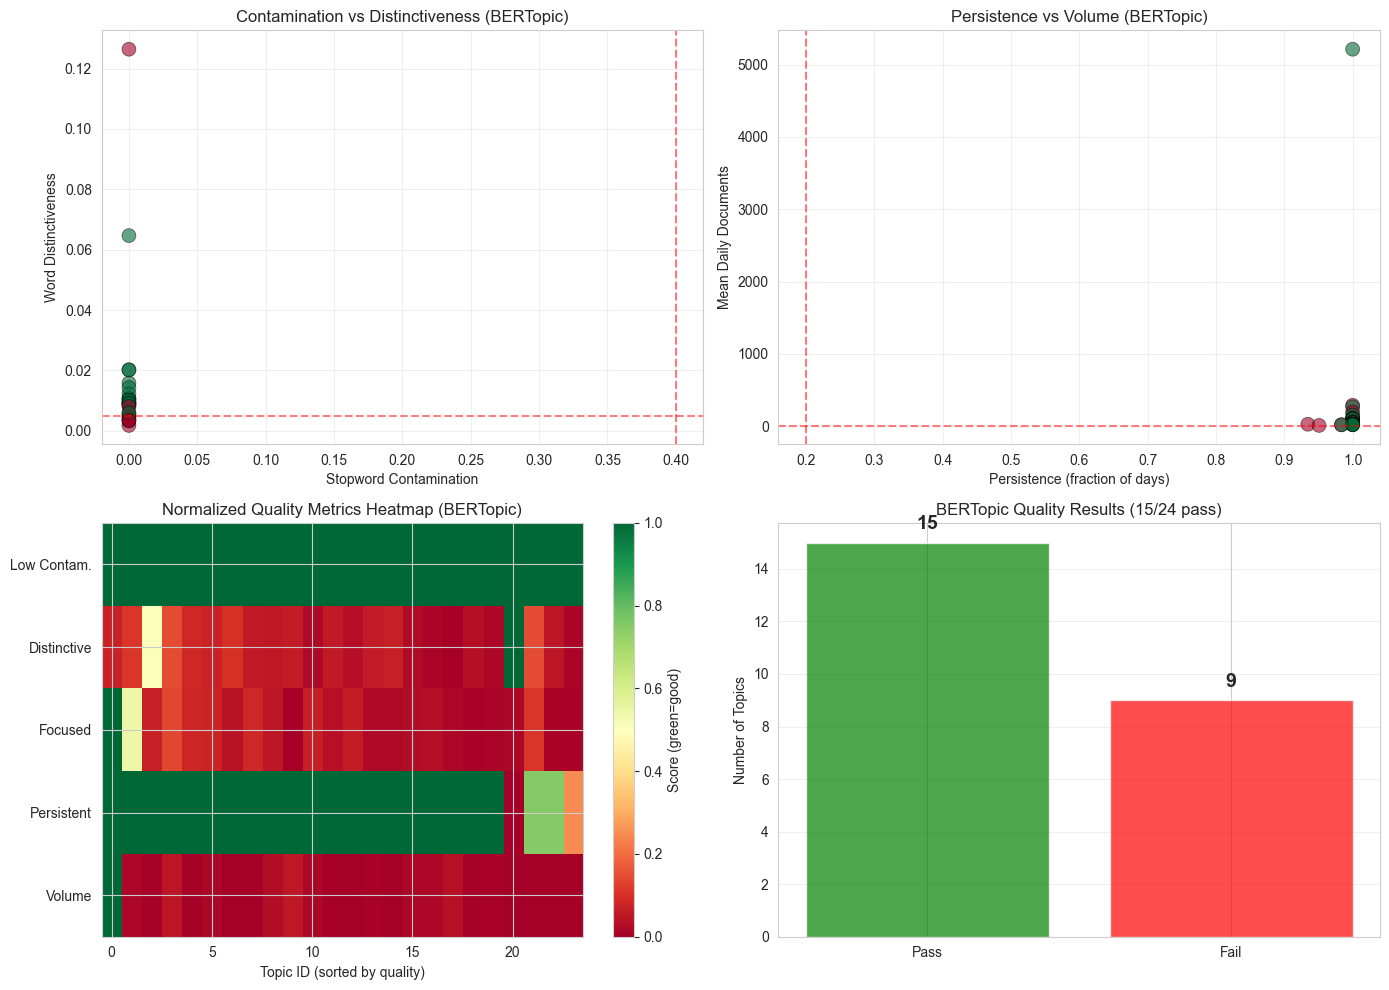

✓ Saved plot: quality_summary.png


In [12]:
# Visualize quality check results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Quality metrics scatter matrix
scatter1 = axes[0, 0].scatter(
    topic_summaries['stopword_contamination'], 
    topic_summaries['word_distinctiveness'],
    c=topic_summaries['passes_all_checks'].astype(int),
    cmap='RdYlGn',
    s=100,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
axes[0, 0].axvline(CONTAMINATION_THRESHOLD, color='red', linestyle='--', alpha=0.5)
axes[0, 0].axhline(distinctiveness_threshold, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Stopword Contamination')
axes[0, 0].set_ylabel('Word Distinctiveness')
axes[0, 0].set_title('Contamination vs Distinctiveness (BERTopic)')
axes[0, 0].grid(alpha=0.3)

# Persistence vs Volume
axes[0, 1].scatter(
    topic_summaries['persistence'], 
    topic_summaries['mean_daily_docs'],
    c=topic_summaries['passes_all_checks'].astype(int),
    cmap='RdYlGn',
    s=100,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
axes[0, 1].axvline(PERSISTENCE_THRESHOLD, color='red', linestyle='--', alpha=0.5)
axes[0, 1].axhline(MIN_DAILY_DOCS, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Persistence (fraction of days)')
axes[0, 1].set_ylabel('Mean Daily Documents')
axes[0, 1].set_title('Persistence vs Volume (BERTopic)')
axes[0, 1].grid(alpha=0.3)

# Quality score heatmap
quality_cols = ['stopword_contamination', 'word_distinctiveness', 'entropy', 'persistence', 'mean_daily_docs']
quality_matrix = topic_summaries[quality_cols].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
quality_matrix_norm = scaler.fit_transform(quality_matrix)
quality_matrix_norm[:, 0] = 1 - quality_matrix_norm[:, 0]  # Invert contamination
quality_matrix_norm[:, 2] = 1 - quality_matrix_norm[:, 2]  # Invert entropy

quality_sum = quality_matrix_norm.sum(axis=1)
sort_idx = np.argsort(quality_sum)[::-1]

im = axes[1, 0].imshow(quality_matrix_norm[sort_idx].T, aspect='auto', cmap='RdYlGn')
axes[1, 0].set_yticks(range(len(quality_cols)))
axes[1, 0].set_yticklabels(['Low Contam.', 'Distinctive', 'Focused', 'Persistent', 'Volume'])
axes[1, 0].set_xlabel('Topic ID (sorted by quality)')
axes[1, 0].set_title('Normalized Quality Metrics Heatmap (BERTopic)')
plt.colorbar(im, ax=axes[1, 0], label='Score (green=good)')

# Pass/fail summary
pass_fail_counts = [n_pass, N_TOPICS - n_pass]
axes[1, 1].bar(['Pass', 'Fail'], pass_fail_counts, color=['green', 'red'], alpha=0.7)
axes[1, 1].set_ylabel('Number of Topics')
axes[1, 1].set_title(f'BERTopic Quality Results ({n_pass}/{N_TOPICS} pass)')
axes[1, 1].grid(alpha=0.3, axis='y')

for i, count in enumerate(pass_fail_counts):
    axes[1, 1].text(i, count + 0.5, str(count), ha='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(output_path / 'quality_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved plot: quality_summary.png")

## 7. Save Quality Assessment Results

In [13]:
# Save updated topic summaries with quality metrics
output_file = bertopic_path / 'bertopic_summaries_with_quality.parquet'
write_parquet(topic_summaries, output_file)
print(f"✓ Saved topic summaries with quality metrics: {output_file}")
print(f"  Shape: {topic_summaries.shape}")

✓ Wrote 24 rows to bertopic_summaries_with_quality.parquet (0.0 MB)
✓ Saved topic summaries with quality metrics: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/bertopic/bertopic_summaries_with_quality.parquet
  Shape: (24, 21)


In [14]:
# Create quality assessment metadata
quality_metadata = {
    'notebook': '16a_reddit_bertopic_quality',
    'timestamp': datetime.now().isoformat(),
    'n_topics': N_TOPICS,
    'methodology': 'fast_heuristics',
    'note': 'Same quality criteria as STM/NMF (notebook 16) for fair comparison',
    'criteria': {
        'stopword_contamination': {
            'threshold': CONTAMINATION_THRESHOLD,
            'definition': 'fraction of top-10 words that are common/stopwords',
            'n_fail': int(n_contamination_fail)
        },
        'word_distinctiveness': {
            'metric': 'mean_ctfidf_weight',
            'threshold_percentile': 20,
            'threshold_value': float(distinctiveness_threshold),
            'n_fail': int(n_distinctiveness_fail)
        },
        'specificity': {
            'metric': 'entropy',
            'threshold_percentile': 80,
            'threshold_value': float(entropy_threshold),
            'definition': 'high entropy = unfocused topic',
            'n_fail': int(n_unfocused_fail)
        },
        'persistence': {
            'threshold': PERSISTENCE_THRESHOLD,
            'definition': 'fraction of days with topic present',
            'n_days': int(n_days),
            'n_fail': int(n_persistence_fail)
        },
        'volume': {
            'min_daily_docs': MIN_DAILY_DOCS,
            'threshold': 'max 50% days below minimum',
            'n_fail': int(n_volume_fail)
        }
    },
    'results': {
        'n_pass_all': int(n_pass),
        'n_fail_any': int(N_TOPICS - n_pass),
        'pass_rate': float(n_pass / N_TOPICS),
        'topics_passing': topic_summaries[topic_summaries['passes_all_checks']]['topic_id'].tolist(),
        'topics_failing': topic_summaries[~topic_summaries['passes_all_checks']]['topic_id'].tolist()
    }
}

metadata_file = output_path / 'quality_assessment_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(quality_metadata, f, indent=2)

print(f"\n✓ Saved quality assessment metadata: {metadata_file}")


✓ Saved quality assessment metadata: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/bertopic/quality_checks/quality_assessment_metadata.json


In [15]:
# Display final summary
print("\n" + "="*80)
print("BERTOPICS PASSING ALL QUALITY CHECKS")
print("="*80)

passing_topics = topic_summaries[topic_summaries['passes_all_checks']].sort_values('word_distinctiveness', ascending=False)

if len(passing_topics) > 0:
    print(f"\n{len(passing_topics)} topics ready for downstream forecasting:\n")
    
    for _, row in passing_topics.iterrows():
        print(f"Topic {row['topic_id']:2d} | "
              f"contam={row['stopword_contamination']:.0%} | "
              f"distinct={row['word_distinctiveness']:.4f} | "
              f"entropy={row['entropy']:.2f} | "
              f"persist={row['persistence']:.0%} | "
              f"docs/day={row['mean_daily_docs']:.1f}")
        print(f"  {row['top_words_str']}")
        print()
else:
    print("\n⚠️  No topics passed all quality checks!")

# Show worst offenders
print("\n" + "="*80)
print("BERTOPICS FAILING QUALITY CHECKS")
print("="*80)

failing_topics = topic_summaries[~topic_summaries['passes_all_checks']].sort_values('n_failures', ascending=False).head(10)

if len(failing_topics) > 0:
    print(f"\nWorst {len(failing_topics)} topics:\n")
    
    for _, row in failing_topics.iterrows():
        failures = []
        if row['high_contamination']: failures.append(f"contam={row['stopword_contamination']:.0%}")
        if row['low_distinctiveness']: failures.append(f"low_dist={row['word_distinctiveness']:.4f}")
        if row['unfocused']: failures.append(f"entropy={row['entropy']:.2f}")
        if row['low_persistence']: failures.append(f"persist={row['persistence']:.0%}")
        if row['low_volume']: failures.append(f"vol={row['mean_daily_docs']:.1f}")
        
        print(f"Topic {row['topic_id']:2d} ({row['n_failures']} failures: {'; '.join(failures)})")
        print(f"  {row['top_words_str']}")
        print()


BERTOPICS PASSING ALL QUALITY CHECKS

15 topics ready for downstream forecasting:

Topic 14 | contam=0% | distinct=0.0647 | entropy=2.60 | persist=100% | docs/day=33.4
  pence plane, brakes pence, train trump, travel alpha, centauri 367, 367 light, days travel, mph rate, away bot, centauri

Topic  2 | contam=0% | distinct=0.0202 | entropy=2.52 | persist=100% | docs/day=269.5
  terrorist terrorist, sdf, ypg, pkk, nusra, hama, hezbollah, bab, idlib, pyd

Topic 22 | contam=0% | distinct=0.0202 | entropy=2.55 | persist=98% | docs/day=19.9
  dakota access, access pipeline, amy goodman, sioux, trespass, rock sioux, dapl, pipeline company, easement, pipeline protest

Topic  8 | contam=0% | distinct=0.0159 | entropy=2.02 | persist=100% | docs/day=108.3
  earpiece hillary, hillary earpiece, parkinson disease, diagnosed pneumonia, hearing aid, walking pneumonia, bacterial pneumonia, phlegm, release medical, heat exhaustion

Topic 15 | contam=0% | distinct=0.0143 | entropy=2.64 | persist=100% | 

## 8. Compare with STM/NMF Quality Results

Load STM quality results for direct comparison.

In [16]:
# Load STM quality results
stm_path = get_data_path('topics', 'reddit')
stm_summaries = read_parquet(stm_path / 'topic_summaries_with_quality.parquet')

print("="*80)
print("COMPARISON: BERTopic vs STM/NMF Quality")
print("="*80)

stm_pass = stm_summaries['passes_all_checks'].sum()
bert_pass = topic_summaries['passes_all_checks'].sum()

print(f"\nSTM/NMF (K=25):")
print(f"  Topics: 25")
print(f"  Passing quality checks: {stm_pass} ({stm_pass/25:.0%})")
print(f"  Failing quality checks: {25-stm_pass} ({(25-stm_pass)/25:.0%})")

print(f"\nBERTopic (K={N_TOPICS}):")
print(f"  Topics: {N_TOPICS}")
print(f"  Passing quality checks: {bert_pass} ({bert_pass/N_TOPICS:.0%})")
print(f"  Failing quality checks: {N_TOPICS-bert_pass} ({(N_TOPICS-bert_pass)/N_TOPICS:.0%})")
print(f"  Outliers (topic -1): {metadata['data']['n_outliers']:,} documents")

print(f"\n{'Criterion':<25} {'STM Failures':<15} {'BERTopic Failures':<15}")
print("-" * 80)
print(f"{'Contamination':<25} {stm_summaries['high_contamination'].sum():<15} {topic_summaries['high_contamination'].sum():<15}")
print(f"{'Low Distinctiveness':<25} {stm_summaries['low_distinctiveness'].sum():<15} {topic_summaries['low_distinctiveness'].sum():<15}")
print(f"{'Unfocused':<25} {stm_summaries['unfocused'].sum():<15} {topic_summaries['unfocused'].sum():<15}")
print(f"{'Low Persistence':<25} {stm_summaries['low_persistence'].sum():<15} {topic_summaries['low_persistence'].sum():<15}")
print(f"{'Low Volume':<25} {stm_summaries['low_volume'].sum():<15} {topic_summaries['low_volume'].sum():<15}")

print(f"\nInterpretation:")
if bert_pass > stm_pass:
    print(f"✓ BERTopic produces {bert_pass - stm_pass} more usable topics than STM/NMF")
elif bert_pass < stm_pass:
    print(f"⚠️  STM/NMF produces {stm_pass - bert_pass} more usable topics than BERTopic")
else:
    print(f"= Both methods produce equal numbers of usable topics")

print(f"\nNote: BERTopic also identifies {metadata['data']['n_outliers']} outlier documents")
print(f"      These may be unique discourse or noise filtered out by clustering")

COMPARISON: BERTopic vs STM/NMF Quality

STM/NMF (K=25):
  Topics: 25
  Passing quality checks: 16 (64%)
  Failing quality checks: 9 (36%)

BERTopic (K=24):
  Topics: 24
  Passing quality checks: 15 (62%)
  Failing quality checks: 9 (38%)
  Outliers (topic -1): 0 documents

Criterion                 STM Failures    BERTopic Failures
--------------------------------------------------------------------------------
Contamination             1               0              
Low Distinctiveness       5               5              
Unfocused                 5               5              
Low Persistence           0               0              
Low Volume                0               2              

Interpretation:
⚠️  STM/NMF produces 1 more usable topics than BERTopic

Note: BERTopic also identifies 0 outlier documents
      These may be unique discourse or noise filtered out by clustering
